In [1]:
import numpy as np
import torch as th
from torch.autograd import Variable
import random
from matplotlib import pyplot as plt

In [2]:
class ContextBandit:
  def __init__(self, state_size = 10, action_size = 10):
    self.state_size = state_size
    self.action_size = action_size
    self.init_distribution_()
    self.update_state_()

  def get_state(self):
    return self.state_idx

  def choose_arm(self, arm):
    reward = self.get_reward_(arm)
    self.update_state_()
    return reward

  def init_distribution_(self):
    self.mtx = np.random.rand(self.state_size, self.action_size)

  def update_state_(self):
    self.state_idx = np.random.randint(0, self.state_size)

  def get_reward_(self, arm):
    return self.reward_(self.mtx[self.get_state()][arm])

  def reward_(self, prob):
    reward = 0
    # reward value from 0 to action_size based on arm probability
    for i in range(self.action_size):
      if random.random() < prob:
        reward += 1
    return reward

In [3]:
# the model learns the function that maps state to the expected reward for each arm
def bandit_model(state_size, action_size, hidden_dim = 100):
  return th.nn.Sequential(
    th.nn.Linear(state_size, hidden_dim),
    th.nn.ReLU(),
    th.nn.Linear(hidden_dim, action_size),
    th.nn.ReLU()
  )

In [4]:
def softmax(av, tau=1.12):
    n = len(av)
    probs = np.zeros(n)
    for i in range(n):
        softm = ( np.exp(av[i] / tau) / np.sum( np.exp(av[:] / tau) ) )
        probs[i] = softm
    return probs

def one_hot(N, pos, val=1):
    one_hot_vec = np.zeros(N)
    one_hot_vec[pos] = val
    return one_hot_vec

In [14]:
def train1(env, model, state_size, action_size, epochs = 5000, learning_rate=1e-2):
  cur_state = Variable(th.Tensor(one_hot(state_size, env.get_state())))
  optimizer = th.optim.Adam(model.parameters(), lr=learning_rate)
  loss_fn = th.nn.MSELoss(size_average=False)
  # fake running average
  reward_hist = np.zeros(50)
  reward_hist[:] = 5
  plt.xlabel('Plays')
  plt.ylabel('Avg Reward')
  for i in range(epochs):
    y_pred = model(cur_state)
    y_softmax = softmax(y_pred.data.numpy(), tau=2.0)
    y_softmax /= y_softmax.sum() #make sure it is summing up to 1
    choice = np.random.choice(action_size, p=y_softmax) #random choice for exploration
    cur_reward = env.choose_arm(choice)
    one_hot_reward = y_pred.data.numpy().copy()
    one_hot_reward[choice] = cur_reward #override the actual reward value for the arm chosen
    reward = Variable(th.Tensor(one_hot_reward))
    loss = loss_fn(y_pred, reward)
    if i % 50 == 0:
      ravg = np.average(reward_hist)
      reward_hist[:] = 0
      plt.scatter(i, ravg)
    reward_hist[i % 50] = cur_reward
    # we only learn it one step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    cur_state = Variable(th.Tensor(one_hot(state_size, env.get_state())))

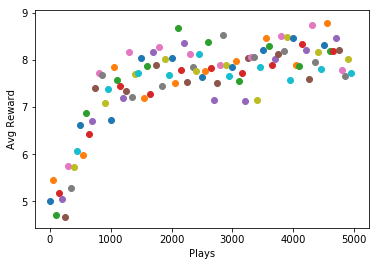

In [15]:
state_size = 20
action_size = 10

env = ContextBandit(state_size, action_size)
model = bandit_model(state_size, action_size)
train1(env, model, state_size, action_size)